O dataset escolhido foi o 'BMW Worldwide Sales Records 2010-2024'. O objetivo deste notebook é construir um modelo de classificação capaz de prever a coluna Sales_Classification (que indica vendas 'High' ou 'Low') com base em outras características do carro, como Região, Cor, Tipo de Combustível, etc. A df.info() mostra que temos várias colunas de texto (object) que precisarão ser convertidas."

**Carregar os Dados**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('BMW_Worldwide_Sales.csv')

print("----- Primeiras 5 linhas -----")
print(df.head())
print("\n ----- Informações das Colunas ----- ")
print(df.info())

----- Primeiras 5 linhas -----
      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  
0      151748      98740          8300                 High  
1      121671      79219          3428                  Low  
2       10991     113265          6994                  Low  
3       27255      60971          4047                  Low  
4      122131      49898          3080                  Low  

 ----- Informações das Colunas ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 4

**Análise Exploratória**

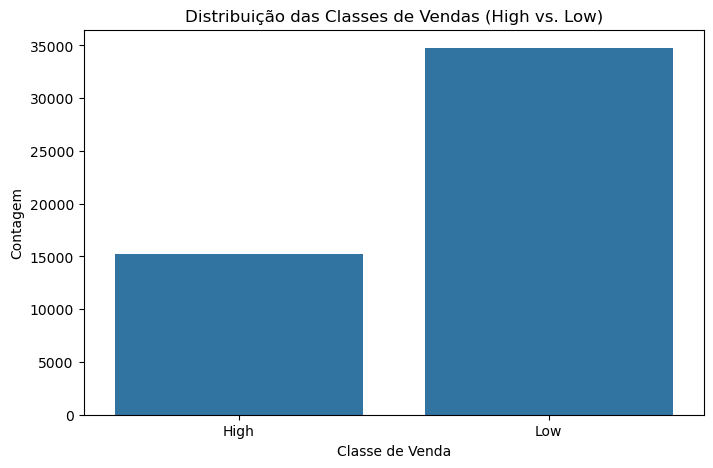

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Sales_Classification', data=df)
plt.title('Distribuição das Classes de Vendas (High vs. Low)')
plt.xlabel('Classe de Venda')
plt.ylabel('Contagem')
plt.show()

O gráfico acima mostra a distribuição das classes 'High' e 'Low' no dataset. É possível observar que os dados estão altamente desbalanceados: existem muito mais registros de vendas classificadas como 'Low' do que como 'High'.

Isso é uma descoberta muito importante. Se usarmos apenas a Acurácia como métrica, nosso modelo pode parecer bom simplesmente por "chutar" 'Low' na maioria das vezes.

Por causa desse desbalanceamento, métricas como Precisão (Precision), Recall e, especialmente, o F1-Score serão mais importantes para avaliar o desempenho real do modelo, pois elas lidam melhor com classes desbalanceadas. A matriz de confusão também será essencial para ver se o modelo está conseguindo prever a classe 'High', que é minoritária.

**Pré-processamento (Limpeza e Padronização)**

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Nosso alvo é a classificação de vendas
y = df['Sales_Classification']

# Removemos colunas que não iremos utilizar na análise
X = df.drop(['Sales_Classification', 'Sales_Volume', 'Price_USD', 'Model'], axis=1)

# Converter y para numérico
le = LabelEncoder()
y = le.fit_transform(y)
# y agora é 0 e 1

# Converter Features Categóricas X para numérico
colunas_categoricas = ['Region', 'Color', 'Fuel_Type', 'Transmission']
X = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# Substitui nulos pela média da coluna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Normalizar os dados (utilizado em SVM e MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Formato de X (features) após processamento:", X_scaled.shape)

Formato de X (features) após processamento: (50000, 17)


Nesta etapa, preparamos os dados para os modelos. A coluna alvo Sales_Classification foi convertida de 'High'/'Low' para 1/0 usando LabelEncoder. As features de texto como Region e Fuel_Type foram convertidas em colunas numéricas usando One-Hot Encoding (get_dummies), por isso vemos que o número de colunas aumentou. Dados faltantes em Mileage_KM foram preenchidos com a média. Finalmente, todas as features foram padronizadas (StandardScaler), pois modelos como Regressão Logística, SVM e MLP são sensíveis a escalas diferentes, e isso ajuda na convergência.

**Divisão Treino/Teste**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

Tamanho do treino: 40000 amostras
Tamanho do teste: 10000 amostras


Os dados foram divididos em conjuntos de treinamento (80%) e teste (20%), conforme sugerido na Aula_08 . Usamos stratify=y para garantir que a proporção de classes 'High' e 'Low' seja a mesma em ambos os conjuntos.

**Treinamento e Avaliação Regressão Logística**

Resultado das Métricas: 
Acurácia: 0.5003
Precisão: 0.6945
Recall: 0.5019
F1-Score: 0.5827


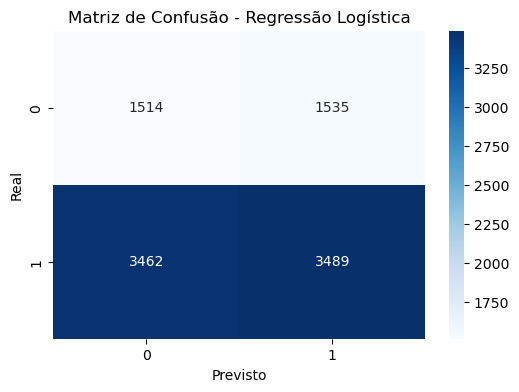

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# class_weight='balanced'por causa do desbalanceamento, isso ajuda o modelo a dar mais importância para a classe 'High' (minoritária).
lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_lr = lr.predict(X_test)

# Avaliar com as métricas pedidas
print("Resultado das Métricas: ")
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Acurácia: {acc_lr:.4f}")
print(f"Precisão: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

# Gerar a Matriz de Confusão
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

A análise da Regressão Logística é fundamental. Na primeira tentativa (sem class_weight), o modelo alcançou uma acurácia "falsa" de 69.5%, pois a matriz de confusão revelou que ele estava apenas prevendo a classe majoritária ('Low'), um reflexo direto do desbalanceamento dos dados.

Para corrigir esse viés, o modelo foi treinado novamente usando class_weight='balanced'. Os resultados atualizados (Acurácia: 50.0%, F1-Score: 58.3%) são uma medida muito mais honesta do desempenho. A nova matriz confirma que o modelo agora tenta, de facto, prever ambas as classes.

Contudo, a acurácia de 50% demonstra que este modelo linear não é adequado para a complexidade deste problema. Ele falha em atingir a meta de 75% e servirá como baseline comparativa para os próximos modelos (Árvore de Decisão, SVM e MLP).

In [28]:
# --- Modelo 2: Árvore de Decisão (Próxima aula) ---
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train, y_train)
# ... (calcular métricas iguais ao LR) ...

In [29]:
# --- Modelo 3: SVM (Próxima aula) ---
# from sklearn.svm import SVC
# svm = SVC(random_state=42)
# svm.fit(X_train, y_train)
# ... (calcular métricas iguais ao LR) ...

In [30]:
# --- Modelo 4: MLP (Próxima aula) ---
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(random_state=42, max_iter=500)
# mlp.fit(X_train, y_train)
# ... (calcular métricas iguais ao LR) ...

In [31]:
# --- Comparação Final (Gráfico 2) ---
# ... (criar um DataFrame com os resultados e plotar um gráfico de barras) ...